# 6. Binary operations, regions

Once a binary mask of interesting objects has been obtained e.g. by thresholding, it is often necessary to correct it. For example some object might have holes, or noisy isolated pixels should be suppressed. This is where binary operation or morphological operations are very useful. These are essentially non-linear operators that turn pixels ON/OFF depending on the local surroundings. Note that a more general class of morphological operators also exist for gray-scale.

Once a clean masks is obtained, the remaining objects can finally be analyzed both on a geometric level (area, shape etc.) and intensity level (e.g. mean intensity of an object in a given channel).

We start by importing the necessary modules, in particular the ```skimage.morphology``` module which provides  the binary operators.

In [175]:
import numpy as np
import matplotlib.pyplot as plt
plt.gray();
import skimage.io as io
from aicsimageio import AICSImage

import skimage.morphology
import skimage.filters

# Load random colormap
from course_functions import random_cmap
cmap = random_cmap()

<Figure size 640x480 with 0 Axes>

We now reload the image from the last chapter and apply some automatic thresholding to it to obtain a binary mask:

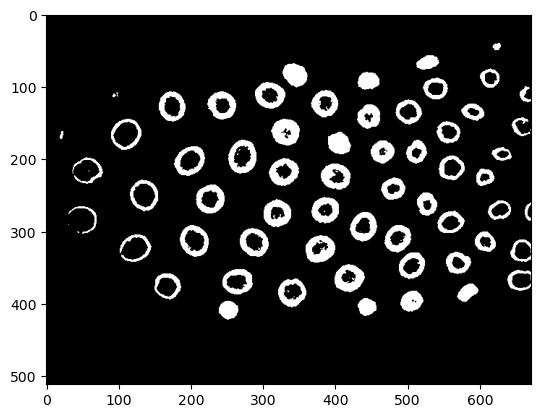

In [176]:
# Load image
data = AICSImage('../Data/30567/30567.tif')
image = data.get_image_data("YX", C=0, T=0, Z=3) 

# Median filter + thresholding
image = skimage.filters.median(image,footprint=np.ones((3,3)))
image_otsu_threshold = skimage.filters.threshold_otsu(image)
image_otsu = image > image_otsu_threshold
plt.imshow(image_otsu);

## 6.1 Binary filters

### 6.1.1. Dilation, erosion

Binary filters turn pixels ON (white) and OFF (black) based on their surrounding. For example we can erode or dilate the image using an area of radius 5. Erosion: If a ON pixel has a OFF neighbor in its surrounding region it becomes black (erode). Dilation: any black pixel which as a white neighbor becomes white.

For a detailed explanation of erosion/dilation see [here](https://realpython.com/image-processing-with-the-python-pillow-library/#image-segmentation-and-superimposition-an-example) under the Erosion and Dilation section.

Just like for regular filtering, the neighborhood is defined thanks to a *selection element*, a binary mask of a certain arbitrary shape. Let's use a disk with two different radii and erode/dilate the mask. We zoom for a moment on a cropped region of the mask:

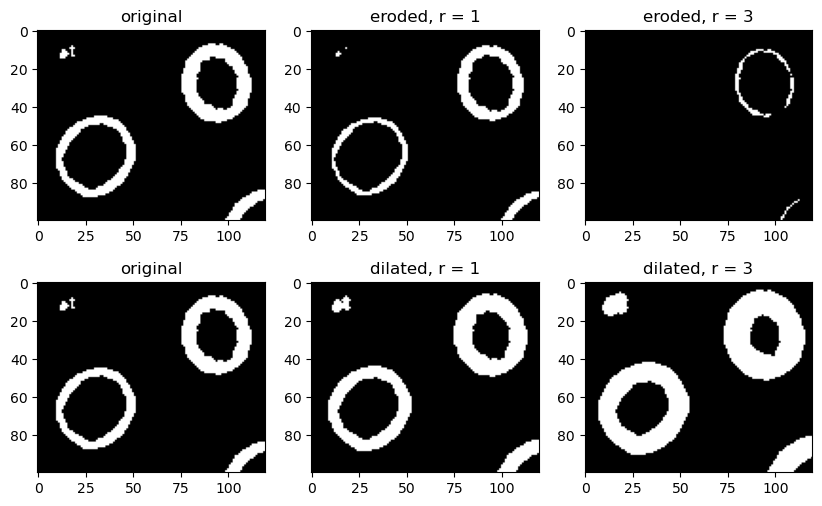

In [177]:
radius = 1
eroded1 = skimage.morphology.binary_erosion(image_otsu, footprint=skimage.morphology.disk(radius))
dilated1 = skimage.morphology.binary_dilation(image_otsu, footprint=skimage.morphology.disk(radius))
radius = 3
eroded2 = skimage.morphology.binary_erosion(image_otsu, footprint=skimage.morphology.disk(radius))
dilated2 = skimage.morphology.binary_dilation(image_otsu, footprint=skimage.morphology.disk(radius))

fig, ax = plt.subplots(2,3, figsize=(10,6))
ax[0,0].imshow(image_otsu[100:200,80:200])
ax[0,0].set_title('original')
ax[0,1].imshow(eroded1[100:200,80:200])
ax[0,1].set_title('eroded, r = 1')
ax[0,2].imshow(eroded2[100:200,80:200])
ax[0,2].set_title('eroded, r = 3')
ax[1,0].imshow(image_otsu[100:200,80:200])
ax[1,0].set_title('original')
ax[1,1].imshow(dilated1[100:200,80:200])
ax[1,1].set_title('dilated, r = 1')
ax[1,2].imshow(dilated2[100:200,80:200])
ax[1,2].set_title('dilated, r = 3');

We see two important effects of these filters: depending on the filter size, erosion can break objects (top right circle) or merge objects (top left "dust"). We thus have to be careful when choosing the scale of the filters.

### 6.1.2 Erosion/dilation combinations

Note that different filers can be applied in series. Let's for example consider this region:

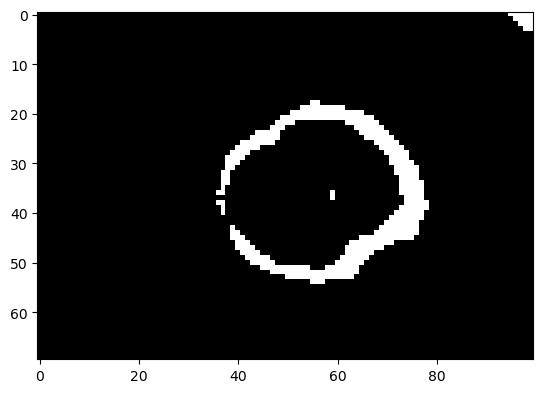

In [178]:
plt.imshow(image_otsu[180:250,0:100]);

We can first dilate the object to create a continuous ring by closing the gap where it's broken. Then we can erode it with a filter of same size to return it to its original thickness:

In [179]:
radius = 5 # You can play with the radius value to see the effect or perform multiple rounds of erosion/dilation
im_dilate = skimage.morphology.binary_dilation(image_otsu, footprint=skimage.morphology.disk(radius))
im_erode = skimage.morphology.binary_erosion(im_dilate, footprint=skimage.morphology.disk(radius))

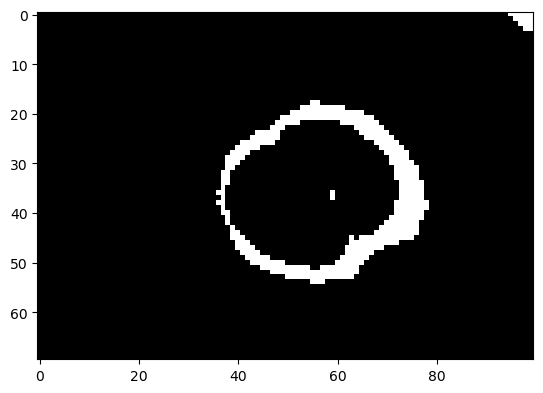

In [180]:
plt.imshow(im_erode[180:250,0:100]);

We have effectively *closed* the object. We could have done the opposite, first erosion then dilation, in order to *open* larger gaps in the object. These operations are so common that they are directly available as functions in skimage as ```skimage.morphology.binary_opening``` and ```skimage.morphology.binary_closing```:

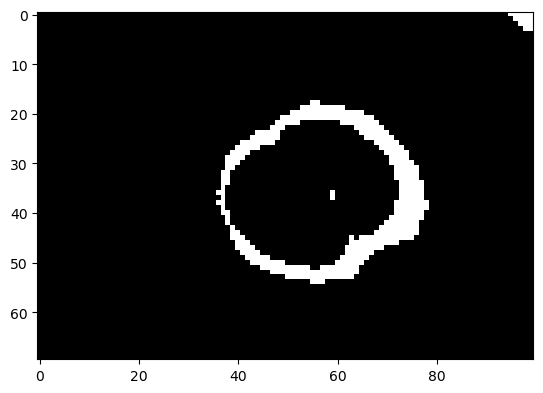

In [181]:
# binary_closing closes small gaps in white regions by performing dilation followed by erosion
im_closing = skimage.morphology.binary_closing(image_otsu, footprint=skimage.morphology.disk(radius))
plt.imshow(im_closing[180:250,0:100]);

For a finer control of the process you can define functions to perform several cycles of erosion and dilation with different radii

In [182]:
def erode(image, cycles, radius=3):
    for _ in range(cycles):
        image = skimage.morphology.erosion(image, footprint=skimage.morphology.disk(radius))
    return image

def dilate(image, cycles, radius=3):
    for _ in range(cycles):
        image = skimage.morphology.dilation(image, footprint=skimage.morphology.disk(radius))
    return image

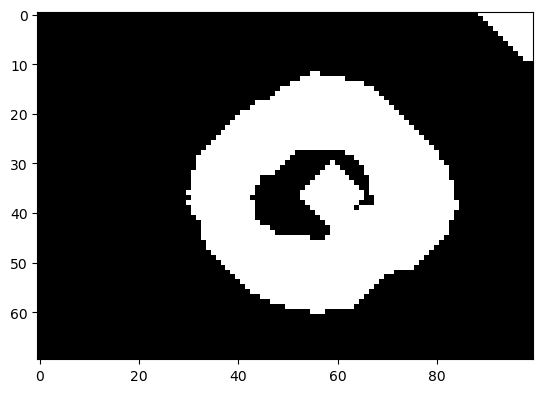

In [183]:
img_dilated_func = dilate(image_otsu[180:250,0:100], cycles=6, radius=1)
plt.imshow(img_dilated_func);

### 6.1.3 Other binary filters

There are many other more complex filters that operate on binary images. For example one can determine the smallest convex shape enclosing ON pixels:

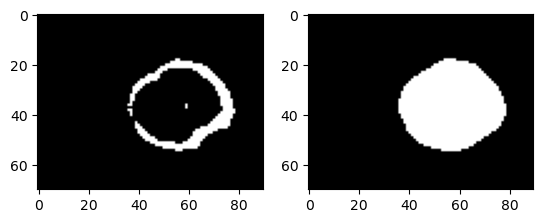

In [184]:
im_convex = skimage.morphology.convex_hull.convex_hull_image(image_otsu[180:250,0:90])
fig, ax = plt.subplots(1,2)
ax[0].imshow(image_otsu[180:250,0:90]);
ax[1].imshow(im_convex);

Or we can obtain the skeleton of these objects by using the skeletonize function:

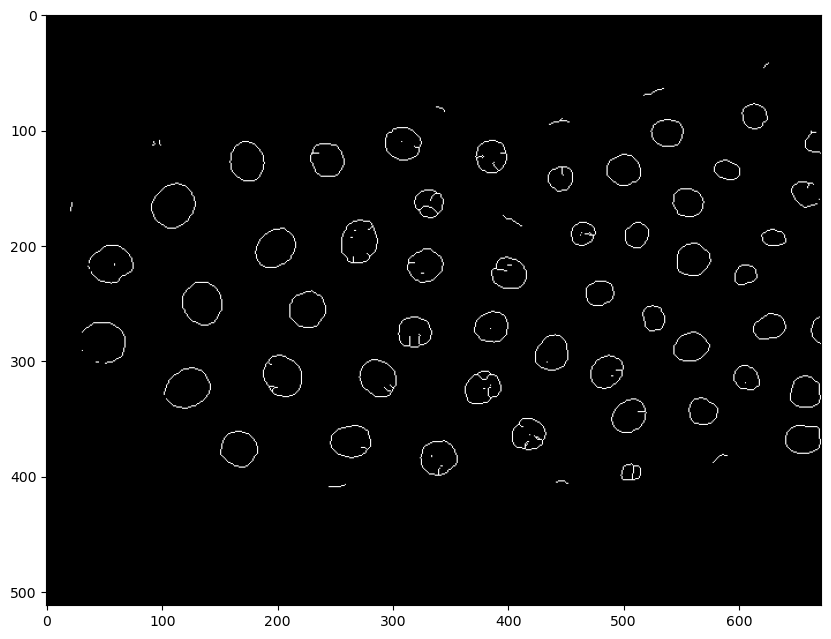

In [185]:
plt.figure(figsize=(10,10))
plt.imshow(skimage.morphology.skeletonize(image_otsu));

## 6.2 Region properties

When a binary mask has been obtained, it is then possible to analyze it to define as objects each region of connected ON pixels, i.e. we can **label** the objects in the image. Using this labelled image, we can then measure the properties of all these objects or **regions of interest (ROIs)**. We will show here how we can combine morphological operations, labeling and region measurements to isolate "interesting" objects from the noisy picture we previously obtained when using a local filter.

First we import the two essential function: ```skimage.measure.label``` and ```skimage.measure.regionprops_table``` (not that there is an alternative ```skimage.measure.regionprops``` function yielding the same measurements but in a less useful format).

In [186]:
from skimage.measure import label, regionprops_table

Remember that we previously used a local filter on the image. The advantage was that it nuclei preserved all nuclei, however at the cost of intense background signal:

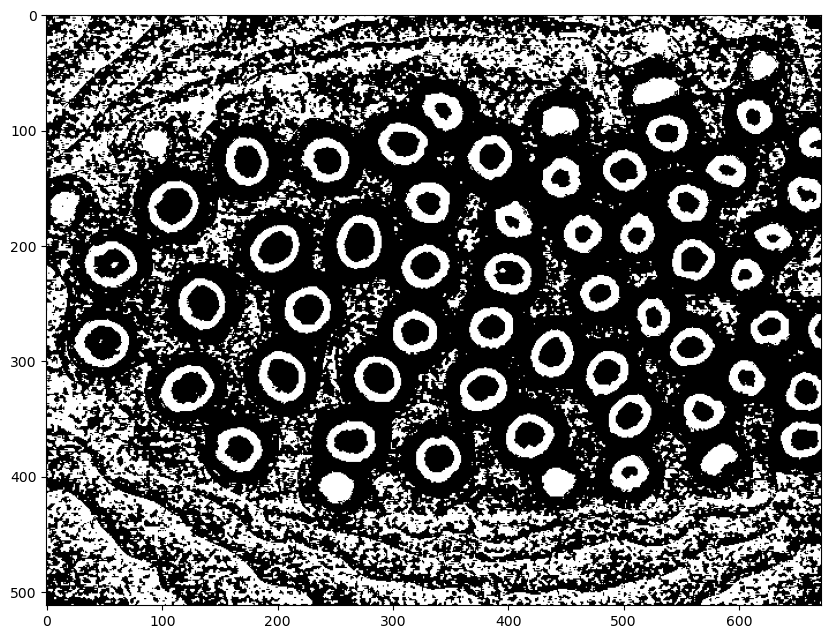

In [208]:
image_local_threshold = skimage.filters.threshold_local(image,block_size=51)
image_local = image > image_local_threshold

plt.figure(figsize=(10,10))
plt.imshow(image_local);

We see a large number of small white regions, and applying region measurements on such an image will be very inefficient. So we first perform an opening to suppress small regions:

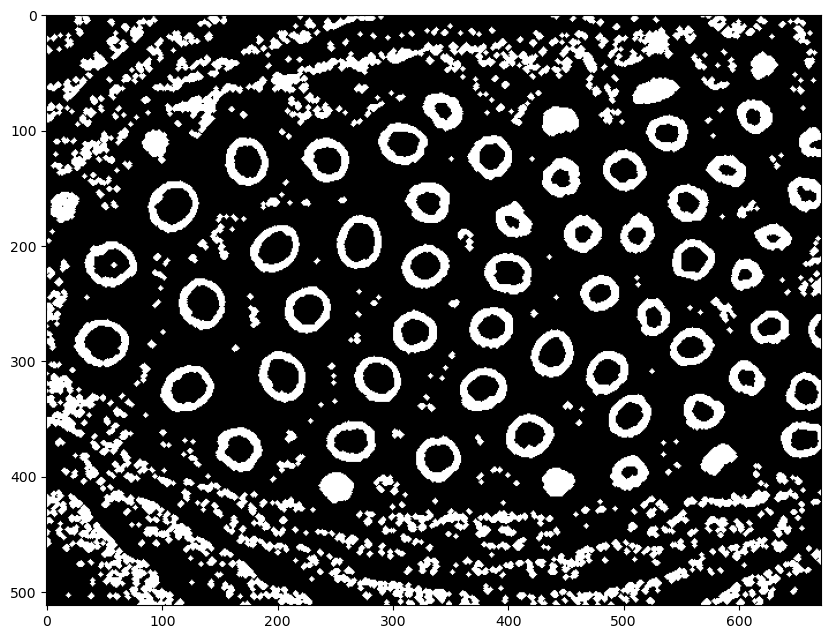

In [209]:
image_local_open = skimage.morphology.binary_opening(image_local, footprint=skimage.morphology.disk(2))

plt.figure(figsize=(10,10))
plt.imshow(image_local_open);

To measure the properties of each region, we need a labeled image, i.e. an image in which each individual object is attributed a number. This is achieved using the skimage.measure.label() function. 

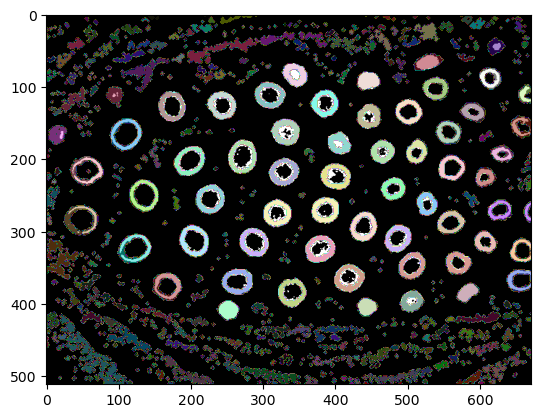

In [210]:
image_labeled = label(image_local_open)
plt.imshow(image_otsu)
plt.imshow(image_labeled, cmap = cmap);

In [211]:
image_labeled.max()

574

The maximum label is 574, i.e. we have 574 separate objects in our mask. Now we can measure all the objects' properties. When using ```regionprops_table``` we need to specify which properties we want to measure (for a list see the [documentation](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops)). In general we can recover four types of information:

- geometric information on each shape (area, extent, perimeter, bounding box, etc.)
- vector information (pixel coordinates, centroid)
- region image information (average intensity, minimal intensity etc.)
- image-type information: e.g. a cropped image of each region to the size of its bounding-box

Here we will keep the area, the eccentricity (a "roundness" measure), and image, a cropped image of each region:

In [212]:
our_regions = regionprops_table(image_labeled, properties=('label', 'area','eccentricity','image','coords'))

The output is a dictionary with keys corresponding to the properties containing an array of values:

In [213]:
print(type(our_regions))
our_regions

<class 'dict'>


{'label': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
        105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
        118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
        131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
        144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
        157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176,

In [215]:
our_regions.keys()

dict_keys(['label', 'area', 'eccentricity', 'image', 'coords'])

For example the area key is a list of areas in pixels:

In [216]:
our_regions['area']

array([  97.,  213.,  101.,   17.,  260.,   13.,   31.,   92.,   34.,
        135.,   18.,   27.,   18.,   41.,   58.,   58.,   29.,   49.,
        202.,   24.,   38.,   13.,   13.,   27.,   28.,  175.,  131.,
         38.,   28.,   21.,  515.,   13.,   40.,   41.,   18.,   27.,
        205.,  208.,  230.,   18.,   13.,   45.,   60.,   13.,   41.,
         13.,   53.,   62.,   18.,   13.,   25.,   79.,   13.,   34.,
         13.,  127.,   21.,  140.,   75.,   52.,   23.,   76.,  341.,
         31.,   41.,  417.,  336.,   30.,   89.,   18.,   21.,   13.,
         39.,   13.,  177.,   18.,   35.,  368.,  229., 1005.,  380.,
         13.,   13.,  171.,   91.,  189.,   21.,   35.,  222.,  216.,
         18.,  162.,   60.,   64.,   18.,   13.,   13.,   18.,   49.,
         13.,  307.,   23.,   13.,   18.,   13.,  104.,   23.,   24.,
        233.,   18.,  116.,   41.,  142.,  648.,   13.,   13.,   65.,
         34.,  862.,   68.,  105.,  100.,   48.,   13.,   18.,   26.,
         74.,  676.,

Let us look at one region:

In [224]:
our_regions['area'][200]

765.0

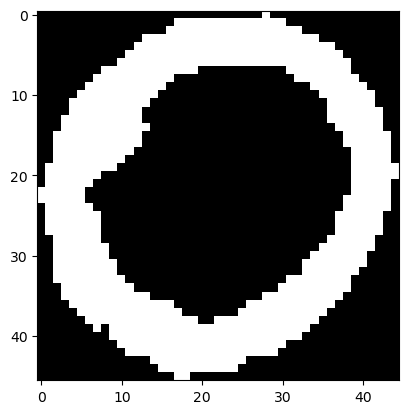

In [223]:
plt.imshow(our_regions['image'][200])

Since we now the labels of these regions, we can do things like recovering only certain labels in the image:

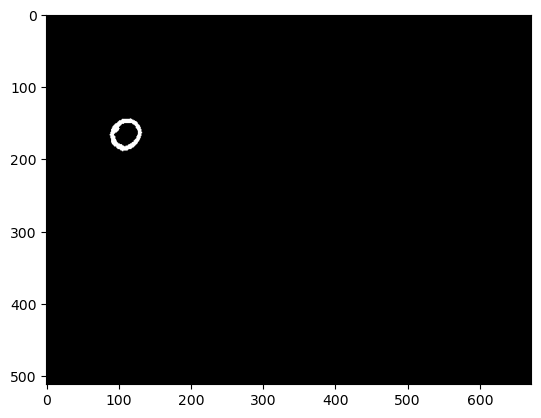

In [226]:
plt.imshow(image_labeled == our_regions['label'][200])

In general, one has an idea about the properties of the objects that are interesting. For example, here we know that objects contain at least several tens of pixels. Let us recover all the areas and look at their distributions:

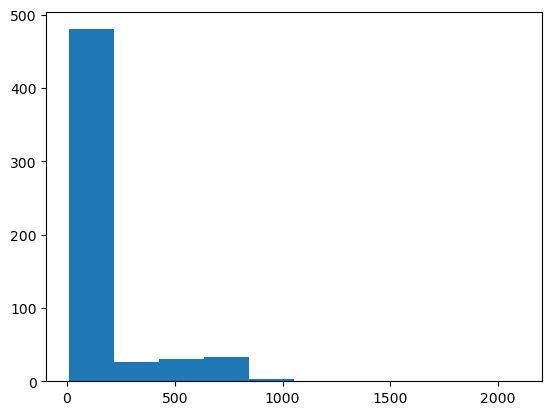

In [227]:
plt.hist(our_regions['area'])
plt.show()

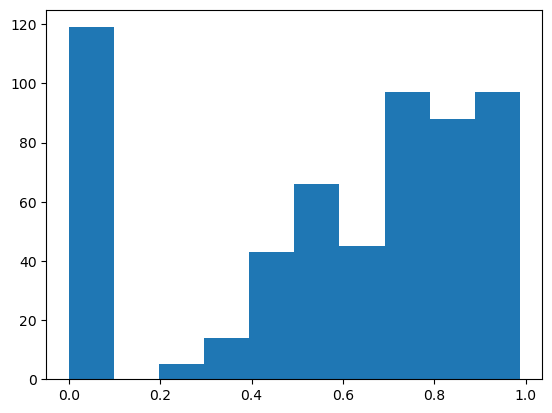

In [228]:
plt.hist(our_regions['eccentricity'])
plt.show()

In [229]:
our_regions['coords'][3]

array([[  0, 219],
       [  0, 220],
       [  0, 221],
       [  1, 218],
       [  1, 219],
       [  1, 220],
       [  1, 221],
       [  1, 222],
       [  2, 218],
       [  2, 219],
       [  2, 220],
       [  2, 221],
       [  2, 222],
       [  3, 219],
       [  3, 220],
       [  3, 221],
       [  4, 220]], dtype=int64)

We see that we have a large majority of regions that are very small and that we can discard. We can put a threshold and fill an empty mask with the conserved regions. We will show two ways of doing that. First, using the region coordinates:

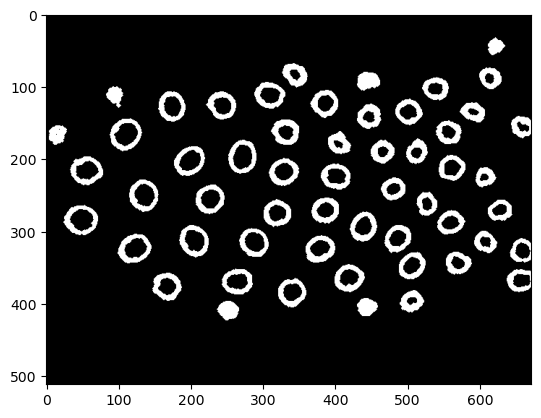

In [261]:
# Create a zero image with the same size (shape) as the original image
newimage = np.zeros(image.shape)
# Fill in using region coordinates, each iteration of the loop will "paint" one ROI on newimage
for x in range(len(our_regions['area'])): # Iterates over all ROIs
    if our_regions['area'][x]>300 and our_regions['area'][x]<800 and our_regions['eccentricity'][x]<0.7: # You can use logical operators to filter by area (bigger than and smaller than) or eccentricity
        # Let's break down the array below newimage[x_coord, y_coord]
        # x_coord = our_regions['coords'] will select the key coords in our_regions dictionary
        # x_coord = our_regions['coords'][x] will iterate over all arrays containing the coordinates of all pixels belonging to a ROI
        # x_coord = our_regions['coords'][x][:,0] will select all x coordinates of all pixels belonging to a ROI 
        # y_coord = our_regions['coords'][x][:,1] will select all y coordinates of all pixels belonging to a ROI 
        newimage[our_regions['coords'][x][:,0],our_regions['coords'][x][:,1]] = 1 # Assign a pixel value of 1 to the regions that are True for the above if statement
        
# Plot the result
plt.imshow(newimage)

We can check how good the segmentation is by superposing the mask (newimage) we just created

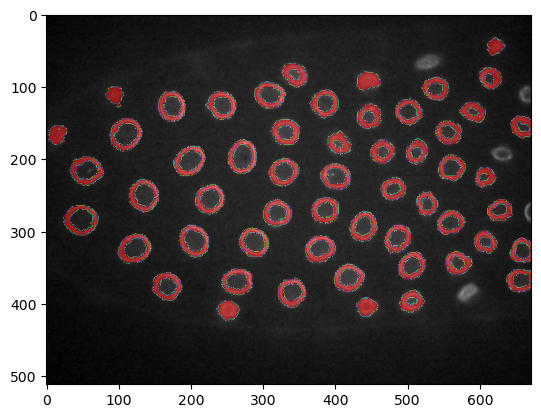

In [262]:
plt.imshow(image,cmap = 'gray')
plt.imshow(newimage,cmap = cmap);

Applying connected components you can use the ```label()``` function from skimage.measure module. This function assigns a unique label (integer) to each connected component in the binary image.

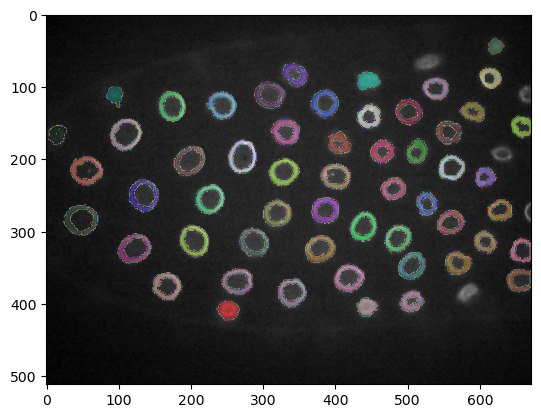

In [256]:
newimage_labels = label(newimage)
plt.imshow(image,cmap = 'gray')
plt.imshow(newimage_labels,cmap=cmap);

For people interested in a more elegant but less flexible solution (you can filter based on just one condition), we can also select the labels to keep by numpy indexing. We first create a list of indices to conserve. If the *index* at position *index* should be discarded it is replaced by 0:

In [202]:
indices_to_keep = np.array([x if x-1 in np.argwhere(our_regions['area']>300) # The subtraction of 1 is used to align the indices with the label values (label values start at 1)
 else 0 for x in range(our_regions['label'].max()+1)])

Now we can index that list (array) with the labelled image. In that way each label in the image will take the value of the corresponding index in our list, and therefore labels that were discarded are replaced by zero. If this is not entirely clear, consult the [numpy indexing docs](https://numpy.org/doc/stable/user/basics.indexing.html)).

In [203]:
kept_labels = indices_to_keep[image_labeled]

In [204]:
np.unique(kept_labels)

array([  0,  17,  19,  23,  35,  41,  43,  44,  46,  48,  49,  50,  51,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  77,  78,  79,
        80,  81,  82,  83,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  96,  97,  98, 100, 101, 102, 103, 105, 106, 107, 109, 111,
       112, 114, 125, 126, 176])

In [205]:
kept_labels.shape

(512, 672)

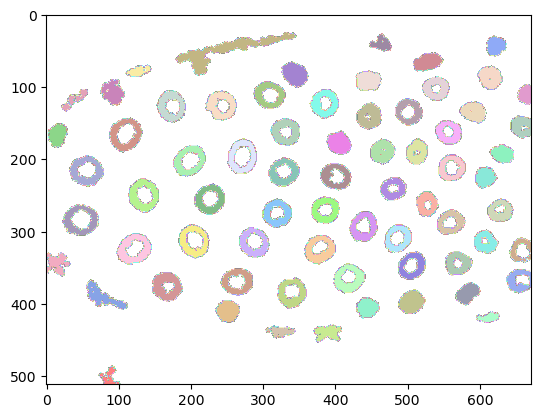

In [206]:
# Each label is populated by the same pixel values shown above under (np.unique(kept_labels))
plt.imshow(kept_labels, cmap=cmap); # Each pixel value is represented by a different color (i.e. all pixels_values of 67 are displayed as light_green)

We can verify how good the segmentation is by superposing it to the image.

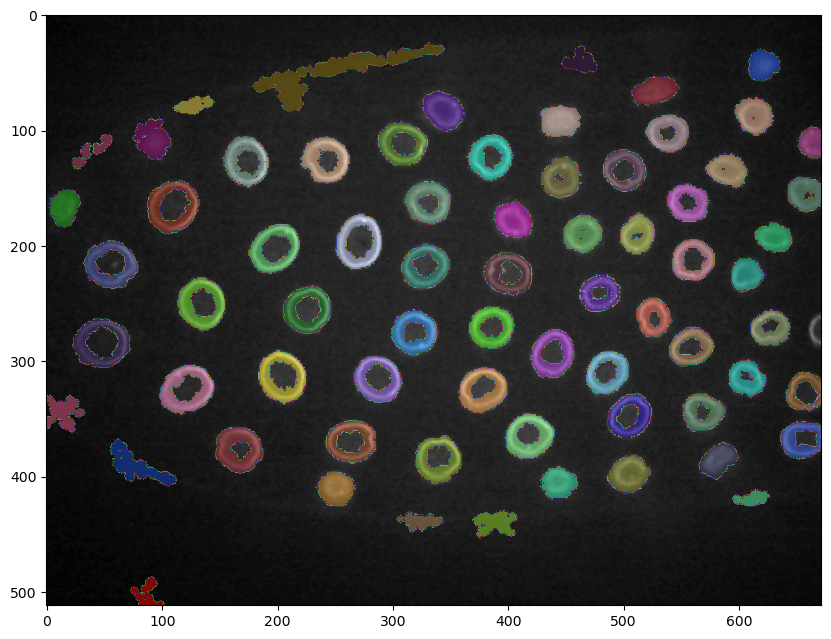

In [207]:
plt.figure(figsize=(10,10))
plt.imshow(image,cmap = 'gray')
plt.imshow(kept_labels,cmap = cmap);